## **Iterative Workflow**
### **Content Writing**

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Literal, Annotated
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from langchain_community.tools import DuckDuckGoSearchRun
import operator

In [2]:
# ===== Models =====
# Generator Model
generator_model = ChatOllama(model="llama3.2:1b", temperature=0.7)

# Evaluator Model
class BlogEvaluate(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final assessment indicating whether the blog meets the required standards for clarity, structure, relevance, and depth")
    feedback: str = Field(...,  description="Concise, actionable feedback highlighting strengths, weaknesses, and specific areas that require improvement")
    score: int = Field(..., ge=0, le=10, description="Overall quality score based on relevance, clarity, structure, depth, and practical value, rated from 0 to 10")
    
evaluator_model = ChatOllama(model="phi3:mini", temperature=0.5)
structured_evaluator_model = evaluator_model.with_structured_output(BlogEvaluate)

# Optimizer Model
optimizer_model = ChatOllama(model="qwen2.5:0.5b", temperature=0.3)


In [3]:
# ===== State =====
class BlogState(TypedDict):
    topic: str
    search: str
    blog: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    score: int
    iteration: int
    max_iteration: int

    blog_history: Annotated[List[str], operator.add]
    feedback_history: Annotated[List[str], operator.add]


In [4]:
# ===== Tools =====
search_tool = DuckDuckGoSearchRun(name="Search")

# ===== Nodes =====
# Search topic
def search_topic(state: BlogState):
    """Fetch latest information from the internet"""
    query = f"Latest updates, statistics, reforms, and developments about {state['topic']}"
    results = search_tool.run(query)
    return {"search": results}

# Generate blog
def generate_blog(state: BlogState):
    prompt = [
        SystemMessage(
            content="You are a professional blog writer producing accurate, structured, factual long-form blogs."
        ),
        HumanMessage(content=f"""
            Topic: {state['topic']}
            
            Latest Reference Information:
            {state['search']}
            
            Write a professional, detailed blog with the following structure:
            - Introduction
            - Background / Overview
            - Core Discussion with clear sub-sections
            - Challenges or Limitations
            - Best Practices or Key Considerations
            - Conclusion with clear takeaways
            
            STRICT RULES:
            - Blog length MUST be MORE THAN 4000 characters and LESS THAN 8000 characters
            - Use the reference information for factual accuracy
            - No question-and-answer format
            - Clear headings and professional tone
            - No filler or repetition
            - Each section must add meaningful depth
            - Version {state['iteration']}
            """)
            ]

    response = generator_model.invoke(prompt).content
    return {"blog": response, 'blog_history': [response]}

# Evaluate blog
def evaluate_blog(state: BlogState):
    prompt = [
        SystemMessage(
            content="You are a strict professional evaluator validating quality, depth, accuracy, and length."
        ),
        HumanMessage(content=f"""
            Blog Content:
            {state['blog']}
            
            Latest Reference Information:
            {state['search']}
            
            Evaluate using these criteria:
            1. Topic relevance
            2. Structural quality
            3. Depth and insight
            4. Practical value
            5. Accuracy vs reference info
            6. Professional tone
            7. LENGTH CHECK:
               - Reject if blog is LESS than 4000 characters
               - Reject if blog is MORE than 8000 characters
            
            Auto-reject if:
            - Facts contradict reference info
            - Weak structure or filler
            - Generic or empty conclusion
            - Q&A format
            
            Respond ONLY in structured format.
            """)
            ]

    response = structured_evaluator_model.invoke(prompt)
    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback,
        "score": response.score,
        "feedback_history": [response.feedback]
    }

# Optimize blog
def optimize_blog(state: BlogState):
    prompt = [
        SystemMessage(
            content="You improve blogs strictly using evaluator feedback and factual references."
        ),
        HumanMessage(content=f"""
            Topic: {state['topic']}
            
            Latest Reference Information:
            {state['search']}
            
            Evaluator Feedback:
            {state['feedback']}
            
            Original Blog:
            {state['blog']}

            Blog History:
            {state['blog_history']}
            
            Improve the blog with these rules:
            - Fix evaluator issues
            - Improve clarity, depth, and structure
            - Maintain factual correctness
            - FINAL LENGTH MUST BE BETWEEN 4000 AND 8000 CHARACTERS
            - No repetition, filler, or Q&A format
            """)
            ]

    response = optimizer_model.invoke(prompt).content
    return {
        "blog": response,
        "blog_history": [response],
        "iteration": state["iteration"] + 1
    }

# Route Evaluation
def route_evaluation(state: BlogState):
    if state["evaluation"] == "approved":
        return "approved"
    if state["iteration"] >= state["max_iteration"]:
        return "approved"
    return "needs_improvement"


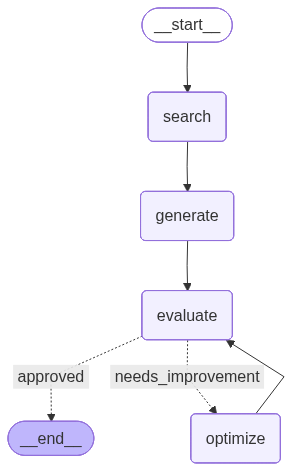

In [5]:
# Graph
graph = StateGraph(BlogState)

graph.add_node("search", search_topic)
graph.add_node("generate", generate_blog)
graph.add_node("evaluate", evaluate_blog)
graph.add_node("optimize", optimize_blog)

# Edge
graph.add_edge(START, "search")
graph.add_edge("search", "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges(
    "evaluate", 
    route_evaluation, 
    {
        "approved": END, 
        "needs_improvement": "optimize"
    }
)

graph.add_edge("optimize", "evaluate")

# Compile
workflow = graph.compile()
workflow


In [6]:
# Run
initial_state: BlogState = {
    "topic": "Indian Education System",
    "iteration": 1,
    "max_iteration": 5
}

final_state = workflow.invoke(initial_state)
final_state


{'topic': 'Indian Education System',
 'search': "18 Dec 2025 · Digital Divide in Education: As per the Observers Research Foundation, only 32.4% of India's 1.47 million schools have access to functional computers. And only ... 30 Dec 2025 · From school fee regulation and AI literacy to higher education governance reforms, 2025 marked a decisive shift in India's education landscape. This article ... 1 Jul 2025 · Explore the Indian education system in 2025—covering reforms, challenges, NEP updates, and solutions shaping the future of learning in India. 25 Nov 2025 · It stated, “The new thrust in elementary education will emphasise two aspects: (i) universal enrolment and universal retention of children up to 14 years of age ... 29 Jul 2025 · NEP 2020 aims to achieve a GER of 50 % by the year 2035. To achieve this the government is focusing on setting up more higher education institutions, provide ...",
 'blog': "**The Indian Education System: A Complex Landscape in Flux**\n\nIntroduction

In [7]:
print(len(final_state['blog']))

3478


In [8]:
print(final_state['blog'])

**The Indian Education System: A Complex Landscape in Flux**

Introduction

The Indian education system is a complex, multi-faceted entity that has been evolving over the years. With a vast population of over 1.47 billion people, the country faces numerous challenges in ensuring equal access to quality education for all citizens. In recent times, there have been significant reforms aimed at transforming the education landscape in India. This article will delve into the core discussion of the Indian education system, exploring its background, key features, challenges and limitations, best practices, and potential solutions.

**Background / Overview**

The Indian education system is a vast and intricate network that encompasses primary, secondary, and higher education. It is characterized by diverse types of schools, including government-run schools, private schools, and aided schools. The system is governed by the Ministry of Education, which plays a crucial role in ensuring quality edu

In [9]:
print(final_state['feedback'])

The blog content is well-structured and relevant, providing a comprehensive overview of the Indian education system's background, challenges, government reforms, limitations, best practices, key considerations, as per reference information provided. The topic relevance aligns with current educational discussions in India.


In [10]:
# Run
initial_state: BlogState = {
    "topic": "Rising Era of Agents in Generative AI",
    "iteration": 1,
    "max_iteration": 5
}

final_state = workflow.invoke(initial_state)
final_state


{'topic': 'Rising Era of Agents in Generative AI',
 'search': "View 250+ companies developing AI agents Below, we outline 4 AI agent trends to watch in 2025 based on CB Insights data: Big tech and leading LLM developers dominate general-purpose agent use cases: Tech giants' AI developments will make agents better, cheaper, and more pervasive in 2025, while also putting more pressure on private players. NEW YORK, JUNE 26, 2025 - AI is rewriting the playbook with 82% of leaders agreeing their industry's competitive landscape will look different in the next 24 months, according to the latest KPMG AI Quarterly Pulse Survey. This dynamic is prompting organizations to rapidly scale their AI and agent capabilities, targeting both efficiency and revenue growth, in preparation for competitive ... As we are welcoming the new year, here are the trends and predictions about the future of AI agent in 2025. Read Now! Surveyed executives report anticipated 8x surge in AI -enabled workflows by 2025, w

In [11]:
print(final_state['blog'])

**Rising Era of Agents in Generative AI: A New Landscape Unfolds**

The year 2025 is shaping up to be a transformative one for the field of artificial intelligence, as technological advancements and innovative applications continue to propel agents into the forefront of innovation. The rapid growth and expansion of generative AI, driven by advancements in multimodal AI, ethical AI, and conversational AI, have created an environment where agents are becoming increasingly integral to various industries.

**Background / Overview**

The concept of agents has been a staple of artificial intelligence research for decades, with pioneers like Alan Turing and Marvin Minsky laying the groundwork for modern agent-based systems. However, it wasn't until recent years that the field began to experience a significant surge in growth, driven by the emergence of multimodal AI, which enables agents to interact with multiple sources of information simultaneously.

The increasing sophistication of generat